<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduksjon" data-toc-modified-id="Introduksjon-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduksjon</a></span></li><li><span><a href="#Setup" data-toc-modified-id="Setup-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Beslutningstrær-(decision-trees)" data-toc-modified-id="Beslutningstrær-(decision-trees)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Beslutningstrær (decision trees)</a></span><ul class="toc-item"><li><span><a href="#Evaluering" data-toc-modified-id="Evaluering-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Evaluering</a></span></li><li><span><a href="#Beslutningsgrenser" data-toc-modified-id="Beslutningsgrenser-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Beslutningsgrenser</a></span></li></ul></li><li><span><a href="#Random-forests:-ensembles-av-beslutningstrær" data-toc-modified-id="Random-forests:-ensembles-av-beslutningstrær-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Random forests: ensembles av beslutningstrær</a></span></li></ul></div>

A.S. Lundervold, 10.01.2020. 

# Introduksjon

Se ELMED219-modulen [Om beslutningstrær, ensembling og random forests](https://mitt.uib.no/courses/21357/pages/om-beslutningstraer-ensembling-og-random-forests?module_item_id=115335) for en introduksjon-

Denne notebooken er ment å støtte opp under denne introduksjonen ved å kort vise hvordan beslutningstrær og random forests konstrueres i scikit-learn.

# Setup

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Data

Vi bruker et velkjent benchmark data set, **breast cancer wisconsin**:

In [ ]:
from sklearn.datasets import load_breast_cancer

breast_dataset = load_breast_cancer()

print(breast_dataset['DESCR'])

Vi konverterer data til en Pandas data frame:

In [ ]:
breast = pd.DataFrame(breast_dataset['data'], columns=breast_dataset['feature_names'])
breast['target'] = breast_dataset['target']

...og, som vanlig, undersøke data:

In [ ]:
breast.head()

In [ ]:
breast.info()

In [ ]:
target_value_count = breast['target'].value_counts()

target_value_count.plot.bar(figsize=(6,6))
plt.show()

Som forventet er det et litt skjevfordelt datasett.

Hva med korrelasjoner?

In [ ]:
correlation_matrix = breast.corr()
correlation_matrix['target'].sort_values(ascending=False)

Vi ser at mange features er sterkt (negativt) korrelert med target. 

Vi lager vår X og y og splitter i trening og test:

In [ ]:
X = breast.drop('target', axis=1)
y = breast['target']

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Beslutningstrær (decision trees)

Her er et plot av to features versus target:

In [ ]:
sns.pairplot(x_vars = 'worst concave points', y_vars = 'worst perimeter', data=breast, hue='target', 
             height=7, plot_kws={"s": 55} # Size of markers
            )
plt.show()

Vi kan bytte ut hvilke to features vi plotter:

In [ ]:
sns.pairplot(x_vars = 'mean area', y_vars = 'mean texture', data=breast, hue='target', 
             height=7, plot_kws={"s": 55} # Size of markers
            )
plt.show()

Vi merker at for disse par av features har instanser markert som brystkreft høyere "worst concave points" og høyere "worst perimeter" enn de markert som negative. Det samme gjelder for "mean area", men i mindre grad for "mean texture". 

For å avgjøre hvorvidt en person har brystkreft eller ikke kunne vi derfor laget et sett med regler med ting som

* «Dersom _worst concave points_ er over 0.13 og _worst perimeter_ samtidig er over 120, prediker brystkreft.»<br>
* «Dersom _mean area_ er over 1000 og _mean texture_ over 17, prediker brystkreft.»
* og så videre

Ved å studere flere features _samtidig_ istedenfor to og to kan slike regler fungere enda bedre.

> **Et sett av slike regler er nøyaktig et beslutningstre!**

Vi kan la scikit-learn bygge treet for oss, og da med alle features:

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
tree_clf = DecisionTreeClassifier(max_depth=3, random_state=42) 

In [ ]:
tree_clf.fit(X_train, y_train)

In [ ]:
from IPython.display import display
from IPython.display import SVG
from sklearn.tree import export_graphviz

In [ ]:
#from graphviz import Source
#graph = Source(export_graphviz(tree_clf, out_file=None, feature_names=X_train.columns, 
#                               class_names=['not cancer','cancer'], filled = True, rounded=True))

In [ ]:
#graph.save('assets/decision_tree_cancer.dot')
#!dot assets/decision_tree_cancer.dot -Tpng > assets/decision_tree_cancer.png

In [ ]:
#display(SVG(graph.pipe(format='svg')))

***NB: Cellen over krever at graphviz er installert på din maskin. Kjør koden nedenfor for å hente inn output som et bilde***

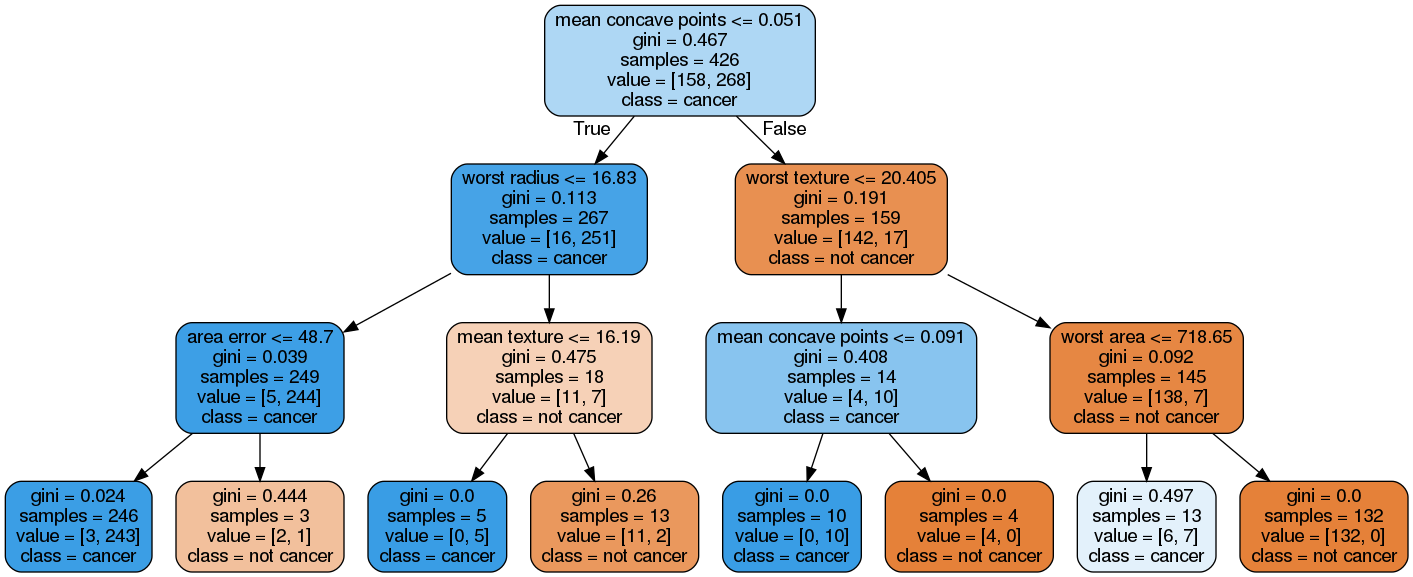

In [1]:
import IPython
IPython.display.Image("assets/decision_tree_cancer.png", width='100%')

Vi ser at vi får noe som kan brukes til prediksjon. Hvis du får i oppgave å klassifisere _cancer_ og _not cancer_ med denne modellen så gjør du som indikert her: 
* Start i **rot-noden**. Det vil si øverst. Hvis _mean concave points_ er 0.051 eller mindre, gå til venstre i treet. Ellers gå til høyre. 
  * Hvis du gikk til venstre, betrakt _worst radius_.
    * Hvis _worst radius_ er mindre eller lik 16.83, gå til venstre. Ellers til høyre. 
      * Hvis du gikk til venstre, betrakt _area error_. Hvis denne er mindre enn 48.7, gå til venstre. Ellers til høyre.
        * Hvis du gikk til venstre så ender du i en **løv-node** (en node der du ikke kan gå videre). Din prediksjon er da `cancer`.
        * Hvis du gikk til høyre er du også i en løv-node. Prediksjonen er da `not cancer`. 
      * Hvis du gikk til høyre, betrakt _mean texture_. Hvis den er mindre enn 16.19, gå til venstre. Ellers til høyre. 
        * osv..
  * Hvis du gikk til høyre, betrakt _worst texture_. Hvis den er mindre enn 20.405, gå til venstre. Ellers til høyre. 
    * osv..

Dette er nøyaktig slik prediksjonene fremkommer dersom du skriver `tree_clf.predict`. Hver instans går gjennom treet slik dens features indikerer inntil en havner i en løv-node, der klassen tilordnes.

## Evaluering

Hvor godt gjør modellen det? 

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
y_pred = tree_clf.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

Hva med dens feil? Er det mange falske negative for eksempel?

In [ ]:
from sklearn.metrics import confusion_matrix
from utils import plot_confusion_matrix

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=['cancer', 'not cancer'])

## Beslutningsgrenser

Vi kan plotte hvordan scikit-learns regler splitter cancer fra ikke-cancer med featuresene vi valgte tidligere.

In [ ]:
from utils import plot_decision_boundary

In [ ]:
X_small = breast[['worst concave points', 'worst perimeter']]
y_small = breast['target']

X_small_train, X_small_test, y_small_train, y_small_test = train_test_split(X_small, y_small, random_state=42
                                                                   )
tree_clf_small = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf_small.fit(X_small_train, y_small_train)

_ = plot_decision_boundary(tree_clf_small, X_small_train, y_small_train)

Om vi øker dybden på treet får vi følgende:

In [ ]:
tree_clf_small_deep = DecisionTreeClassifier(max_depth=4, random_state=42)
tree_clf_small_deep.fit(X_small_train, y_small_train)

_ = plot_decision_boundary(tree_clf_small_deep, X_small_train, y_small_train)

Vi ser at med dypere trær blir reglene til treet *veldig* spesifikke, slik at det blir i stand til å skille så mange av instansene fra hverandre som mulig. 

Dersom reglene blir _for_ spesifikke til treningsdata slik at den fungerer dårlig for nye data (i.e. nye pasienter) sier vi at modellen er **overtilpasset** (**overfit**).

Vi kan undersøke hvorvidt modellen **generaliserer** til nye data ved å sjekke modellens prediksjoner på usette instanser:

In [ ]:
y_pred_small = tree_clf_small.predict(X_small_test)
y_pred_small_deep = tree_clf_small_deep.predict(X_small_test)

In [ ]:
print(f"Accuracy til første tre: {accuracy_score(y_small_test, y_pred_small)}")
print(f"Accuracy til dypere tre: {accuracy_score(y_small_test, y_pred_small_deep)}")

Modellen gjør det dårligere på testdata enn vår den med mindre dybde, selv om den er bedre tilpasset treningsdata.  

Beslutningstrær som får vokse fritt vil alltid overfitte data. Derfor er det viktig å kontrollere `max_depth` og/eller sette andre begrensinger på trærne. 

Et annet problem med beslutningstrær er at de kan være **veldig ustabile**: en liten endring i data som brukes til trening kan gi veldig ulikt tre. 

Beslutningstrær har mange gode egenskaper. De er 
* Enkle å bruke
* Prediksjoner er enkle å tolke
* De kan tilpasse seg kompliserte treningsdata. 

Men de har altså noen veldig store negative egenskaper. De tilpasser seg gjerne treningsdata for godt, og de er veldig sensitive for små variasjoner i hva som brukes som treningsdata. 

> For å bekjempe disse begreningsingene og samtidig beholde mange av de fine egenskapene til beslutningstrær, kan man *ensemble*, det vil si sette sammen, mange trær til én modell. Dette leder en til **random forests**.

# Random forests: ensembles av beslutningstrær

En random forest er et **ensemble** av beslutningstrær. 

Som nevnt i i introduksjonen til random forests er ensembling en mer generell teknikk, anvendbar for alle maskinlæringsmodeller. Ensembling kan motiveres fra konseptet ***wisdom of the crowd***: I mange situasjoner vil en gruppe ikke-eksperter som kombinerer sine prediksjoner utkonkurrere individuelle eksperter. 

Ideen er selvsagt ikke ny. Her er Aristoteles tilbake i 350 BCE:

> For the many, of whom each individual is but an ordinary person, when they meet together may very likely be better than the few good, if regarded not individually but collectively, just as a feast to which many contribute is better than a dinner provided out of a single purse 
– Aristotle, [Politics Book III](http://classics.mit.edu/Aristotle/politics.3.three.html)

> Vi skal fokusere på ensembling nøyaktig slik det brukes for random forests, men vit at det er et mer generelt og svært nyttig konsept i maskinlæring som finnes i en rekke varianter.

Som vi har diskutert, beslutningstrær kan enkeltvis være svært sensitive til den eksakte treningsdataen som brukes, og de har det også med å "overfitte" treningsdata.

Ved å trene flere beslutningstrær hver på litt ulike deler av treningsdata kan hvert enkelt tre være sensitivt, men ved å ta gjennomsnittet av deres prediksjoner kan sensitiviteten reduseres og overfitting-tendensen reduseres. 

La oss si vi ønsker å bygge 500 trær på et treningssett med `n_samples` datapunkt. Hvert tre bygges som følger: 

1. Trekk et datapunkt tilfeldig fra treningsdata. Gjør dette `n_samples` ganger, med tilbakelegging. Altså inntil du har `n_samples` datapunkter. Dette kalles **bootstrap sampling**. Hvert tre vil bli konstruert på ulike datasett. 
2. Tren et beslutningstre på dette datasettet, men ved hver node velg et tilfeldig utvalg av features som treet får vurdere å splitte på, inntil `max_features` antall (et antall vi velger). Hvert tre konstrueres altså basert på ulike features. 

Dette gir oss det som kalles en random forest. 

<img width=60% src="assets/rf_datacamp.PNG">

Prediksjoner fra en random forest gjøres ulikt for klassifikasjon og regresjon:

**Regresjon:** La hvert tre komme med sin prediksjon. Ta deretter gjennomsnittet av disse. <br>
**Klassifikasjon:** La hvert tre komme med sin prediksjon, og kombiner dem ved avstemning, hvor du tar hensyn til hvor sikker hvert tre er på sin prediksjon. Hvert tre produserer en sannsynlighet knyttet til sin prediksjon. Ta gjennomsnittet av disse og prediker klassen med høyest gjennomsnittlig sannsynlighet. 

Vi kan bygge en random forest med scikit-learn:

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf = RandomForestClassifier(n_estimators=500, max_depth=3, random_state=42)

In [ ]:
rf.fit(X_train, y_train)

In [ ]:
rf.score(X_test, y_test)

Vi oppnådde en bedre accuracy med disse 500 beslutningstrærne satt sammen i en random forest enn med vårt enkelt-tre fra tidligere:

In [ ]:
tree_clf.score(X_test, y_test)

In [ ]:
y_pred = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=['cancer', 'not cancer'])
plt.show()